In [579]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [580]:
class Tree():
    def __init__(self, bot_layer, top_layer, team_cost, self_cost):
        self.bot_layer = bot_layer
        self.top_layer = top_layer
        self.team_cost = team_cost
        self.self_cost = self_cost
        
        self.tables = {'T': {'T': (bot_layer+top_layer)/2 - team_cost, 'S': bot_layer/4}, 
                       'S': {'T': bot_layer * 3/4, 'S': bot_layer/2 - self_cost}}
        self.creatures = []
        
    def harvest(self):
        if len(self.creatures) == 0: 
            return
        elif len(self.creatures) == 1:
            self.creatures[0].food = self.bot_layer
        else:
            strain0 = self.creatures[0].strain
            strain1 = self.creatures[1].strain
            
            if self.creatures[0].strain == 'I' and self.creatures[1].strain != 'I':
                strain0 = 'T' if self.tables['T'][self.creatures[1].strain] > self.tables['S'][self.creatures[1].strain] else 'S'
            elif self.creatures[0].strain != 'I' and self.creatures[1].strain == 'I':
                strain1 = 'T' if self.tables['T'][self.creatures[0].strain] > self.tables['S'][self.creatures[0].strain] else 'S'
            elif self.creatures[0].strain == 'I' and self.creatures[1].strain == 'I':
                strain0 = 'T'
                strain1 = 'T'
            
            self.creatures[0].food = self.tables[strain0][strain1]
            self.creatures[1].food = self.tables[strain1][strain0]
            
    def reset(self):
        self.creatures = []

In [581]:
class Creature():
    strains_full = ['Team', 'Selfish', 'Intelligent']
    strains = ['T', 'S', 'I']
    
    def __init__(self, strain):
        self.food = 0
        self.strain = strain
        
    def reproduce(self, mutation_table):
        out = []
        for i in range(int(self.food//1 + ((self.food - self.food//1) > np.random.rand()))):
            new_strain = np.random.choice(self.strains, p=list(mutation_table[self.strain].values()))
            out.append(Creature(new_strain))
        return out
    
    def __str__(self):
        return f'{self.food}, {self.strain}'

In [582]:
class Simulator():
    def __init__(self, init_creatures=10, init_trees=50, mutation_table=np.identity(len(Creature.strains)), bot_layer=2, top_layer=2, team_cost=1/4, self_cost=1/4):
        self.init_creatures = init_creatures
        self.creatures = np.array([Creature('S' if 0.5 > np.random.rand() else 'T') for i in range(init_creatures)])
        
        self.init_trees = init_trees
        self.trees = np.array([Tree(bot_layer, top_layer, team_cost, self_cost) for i in range(init_trees)])
            
        self.evolution = np.array([])
        self.mutation_table = mutation_table
            
    def reset_trees(self):
        for tree in self.trees: tree.reset()
        
    def find_trees(self):
        for i in range(min(2*self.init_trees, len(self.creatures))):
            self.trees[i%self.init_trees].creatures.append(self.creatures[i])
        
    def harvest_trees(self):
        for tree in self.trees: tree.harvest()
        
    def next_gen(self):
        num_creatures = len(self.creatures)
        
        for i in range(num_creatures): 
            self.creatures = np.append(self.creatures, self.creatures[i].reproduce(self.mutation_table))
        for i in range(num_creatures): 
            self.creatures = self.creatures[1:]
            
        np.random.shuffle(self.creatures)
            
    def print_creatures(self):
        for creature in self.creatures: print(str(creature))
        
    def count_creatures(self, strain=None):
        strains = [creature.strain for creature in self.creatures]
        if strain is None: 
            return [strains.count(strain) for strain in Creature.strains]
        else:
            return strains.count(strain)
            
    def day(self):
        self.reset_trees()
        self.find_trees()
        self.harvest_trees()
        self.next_gen()
        
    def run(self, iterations=100):
        counts = self.count_creatures()
        props = [count / len(self.creatures) for count in counts]
        self.evolution = np.append(self.evolution, props)
        
        for i in range(iterations):
            self.day()
            counts = self.count_creatures()
            props = [count / len(self.creatures) for count in counts]
            self.evolution = np.append(self.evolution, props)
            
        self.evolution = self.evolution.reshape(iterations+1, len(Creature.strains)).T
            
    def plot_data(self):
        fig, ax = plt.subplots()
        legend = Creature.strains_full
        ax.stackplot(np.arange(0, self.evolution.shape[1]), *self.evolution, labels=legend)
        ax.legend()
        ax.set(title="Number of Team Creatures Over Time")
        plt.show()

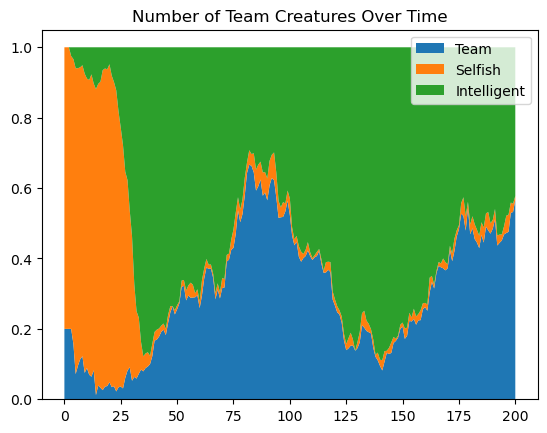

In [583]:
mutation_table = {'T': {'T': 0.98, 'S': 0.01, 'I': 0.01},
                  'S': {'T': 0.01, 'S': 0.98, 'I': 0.01},
                  'I': {'T': 0.01, 'S': 0.01, 'I': 0.98}}
simulator = Simulator(mutation_table=mutation_table)
simulator.run(200)
simulator.plot_data()